# Create primers for mutations in Usher data

This notebooks takes Usher data, compared it to GISAID variant tables, filters it for higher frequency changes and creates primers for all usher sites.

In [ ]:
import pandas as pd
from plotnine import *
from Bio.SeqUtils import MeltingTemp as mt
import statistics

In [ ]:
usher_df = snakemake.input.usher_df
reference_lookup = snakemake.input.reference_lookup
gisaid_mutations = snakemake.input.gisaid_mutations
usher_count_filter = snakemake.params.usher_count_filter
codon_table = snakemake.input.codon_table
spike_extended = snakemake.input.spike_extended
create_primers_srcipt = snakemake.input.create_primers_srcipt

new_usher_df_out = snakemake.output.new_usher_df_out
usher_primers = snakemake.output.usher_primers

In [ ]:
usher_df = pd.read_csv(usher_df)
reference_lookup = pd.read_csv(reference_lookup)
gisaid_mutations = pd.read_csv(gisaid_mutations)

In [52]:
# usher_df = pd.read_csv ("../results/spike_mutcounts.csv")
# reference_lookup = pd.read_csv("../reference_sequences/reference_sequence_position_lookup.csv")
# gisaid_mutations = pd.read_csv("../results/spike_alignment_counts.csv")
# usher_count_filter = 10
# codon_table = "../reference_sequences/homo_codon_freq_del.csv"
# spike_extended = "../reference_sequences/B16172_extended_ends_for_primers.txt"
# create_primers_srcipt = '../scripts/create_primers_del.py'

# new_usher_df_out = '../results/variant_usher_mutations.csv'
# usher_primers = '../results/primers/usher_primers.csv'

## Compare GISAID and Usher data

First check if all mutations on ushed are present in gisaid data, as usher should be a subset of GISAID.

In [53]:
#merge reference_lookup and gisaid_mutations tables
#remove GISAID mutations that are in variant spike already
new_df = pd.merge(gisaid_mutations,
                  reference_lookup,
                  how='left',
                  left_on=['site','amino_acid'],
                  right_on = ['parent_pos','parent_seq'],
                  indicator=True)

#filter on amino acids not already present in variant
new_df_noWU = new_df.loc[(new_df['_merge'] == 'left_only')]
new_gisaid_mutations = new_df[new_df.index.isin(new_df_noWU.index)]
new_gisaid_mutations = new_gisaid_mutations[['site','amino_acid','alignment_counts']]
new_gisaid_mutations

,site,amino_acid,alignment_counts
1,2,M,4
2,27,M,2
3,32,M,3
4,64,M,1
5,68,M,17
...,...,...,...
9080,1209,H,6
9081,474,H,37
9082,901,H,1
9084,983,H,1


In [54]:
#now merge tables just on parent position, remove rows with no usher data, sort by position
new_gisaid_mutations = pd.merge(new_gisaid_mutations,
                  usher_df,
                  how='left',
                  left_on=['site', 'amino_acid'],
                  right_on = ['site', 'amino_acid'])

#drop positions with NaN in parent sequence removed CTD amino acids
new_gisaid_mutations = new_gisaid_mutations[new_gisaid_mutations['n_mutations_to'].notna()]
new_gisaid_mutations = new_gisaid_mutations.sort_values(by=['site'],ignore_index=True )
new_gisaid_mutations

,site,amino_acid,alignment_counts,n_mutations_to
0,1,I,7,1.0
1,1,I,7,2.0
2,2,V,29,1.0
3,2,L,353,42.0
4,2,L,353,11.0
...,...,...,...,...
4935,1272,D,1,1.0
4936,1272,H,76,8.0
4937,1273,I,300,69.0
4938,1273,A,34,3.0


Now plot correlation between usher and GISAID data

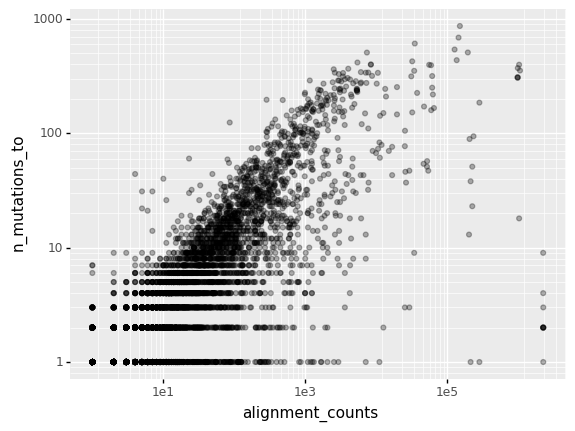

<bound method ggplot.draw of <ggplot: (8770690458260)>>

In [55]:
p = (ggplot(new_gisaid_mutations) + 
     aes('alignment_counts', 'n_mutations_to') + 
     geom_point(alpha = 0.3)+
     scale_x_log10()+
     scale_y_log10()
    )
p.draw

Now look at which mutations in usher are not present in GISAID

In [56]:
usher_df["site_mutations"] = usher_df["site"].astype(str) + usher_df["amino_acid"]
gisaid_mutations["site_mutations"] = gisaid_mutations["site"].astype(str) + gisaid_mutations["amino_acid"]

notInGISAID=usher_df.loc[~usher_df.site_mutations.isin(gisaid_mutations.site_mutations),]
notInGISAID

,site,amino_acid,n_mutations_to,site_mutations
1054,710,I,14,710I
1356,743,S,10,743S
2659,716,S,4,716S
2757,975,I,3,975I
3036,70,D,3,70D
...,...,...,...,...
5483,1213,R,1,1213R
5489,1190,D,1,1190D
5498,1159,N,1,1159N
5501,1142,E,1,1142E


Now plot counts for usher sites not present in GISAID

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


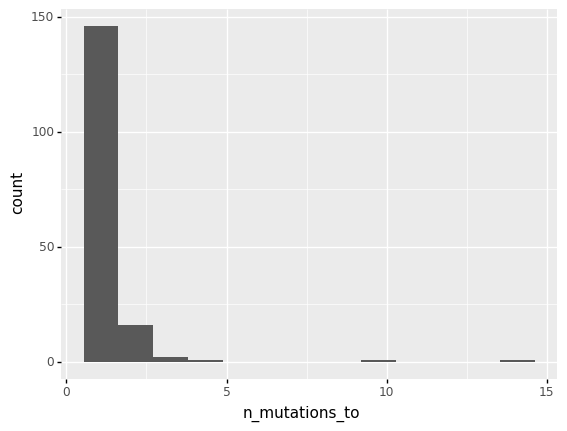

<bound method ggplot.draw of <ggplot: (8770690430296)>>

In [57]:
p = (ggplot(notInGISAID) + 
     aes('n_mutations_to') + 
     geom_histogram()
    )
p.draw

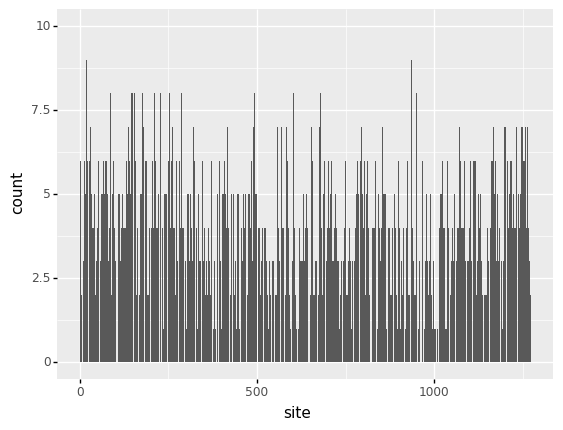

<bound method ggplot.draw of <ggplot: (8770690191026)>>

In [58]:
#plot sites of usher changes
p = (ggplot(new_gisaid_mutations) + 
     aes('site') + 
     geom_bar()
    )

# ggsave(plot = p, filename = 'results/primer_tm_dist.png')
p.draw

## Filter usher dataset

We want to filter usher data for more frequent mutations

In [59]:
#merge lookup and usher tables
#remove mutations that are in variant spike already
new_usher_df = pd.merge(usher_df,
                  reference_lookup,
                  how='left',
                  left_on=['site','amino_acid'],
                  right_on = ['parent_pos','parent_seq'],
                  indicator=True)

#filter on amino acids not already present in variant
new_new_usher_df_noRef = new_usher_df.loc[(new_usher_df['_merge'] == 'left_only') | (new_usher_df['variant_sig'] == 'Yes')]
new_usher_df = new_usher_df[new_usher_df.index.isin(new_new_usher_df_noRef.index)]
new_usher_df = new_usher_df[['site','amino_acid','n_mutations_to']]


In [60]:
#now merge tables just on parent position
new_usher_df = pd.merge(new_usher_df,
                  reference_lookup,
                  how='left',
                  left_on=['site'],
                  right_on = ['parent_pos'])

#drop positions with NaN in parent sequence removed CTD amino acids
new_usher_df = new_usher_df[new_usher_df['parent_pos'].notna()]
new_usher_df = new_usher_df.sort_values(by=['site'],ignore_index=True)
new_usher_df

,site,amino_acid,n_mutations_to,parent_seq,variant_seq,parent_pos,variant_pos,variant_sig
0,1,I,1,M,M,1.0,1.0,No
1,1,I,2,M,M,1.0,1.0,No
2,2,L,42,F,F,2.0,2.0,No
3,2,Y,1,F,F,2.0,2.0,No
4,2,L,11,F,F,2.0,2.0,No
...,...,...,...,...,...,...,...,...
5014,1252,T,2,S,S,1252.0,1250.0,No
5015,1252,Y,7,S,S,1252.0,1250.0,No
5016,1252,P,38,S,S,1252.0,1250.0,No
5017,1252,F,118,S,S,1252.0,1250.0,No


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 82 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


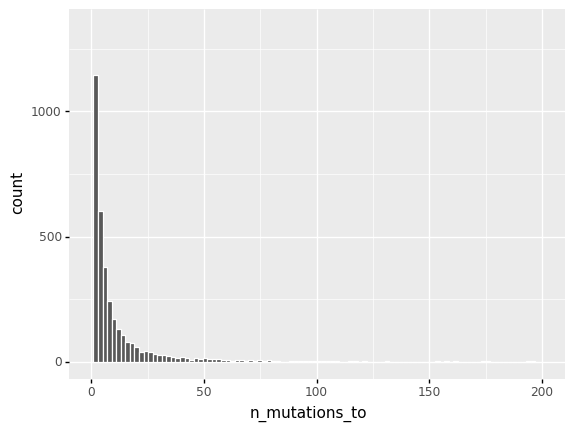

<bound method ggplot.draw of <ggplot: (8770690359863)>>

In [61]:
p = (ggplot(new_usher_df) + 
     aes('n_mutations_to') + 
     geom_histogram(color='white', bins=100)+
     xlim(0,200)
    )

# ggsave(plot = p, filename = 'results/primer_tm_dist.png')
p.draw

In [62]:
#drop mutations that occur less >= <usher_count_filter> times
new_usher_df=new_usher_df.loc[new_usher_df['n_mutations_to'] >= usher_count_filter]
len(new_usher_df)

1312

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 82 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


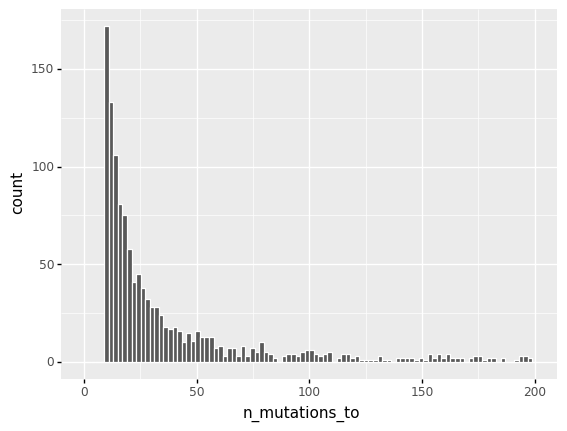

<bound method ggplot.draw of <ggplot: (8770690462504)>>

In [63]:
p = (ggplot(new_usher_df) + 
     aes('n_mutations_to') + 
     geom_histogram(color='white', bins=100)+
     xlim(0,200)
    )

# ggsave(plot = p, filename = 'results/primer_tm_dist.png')
p.draw

Now filter drop columns that we don't need and relabel for variant

In [64]:
#create new table with mutations according to variant numbering
new_usher_df = new_usher_df[['variant_pos', 'amino_acid', 'n_mutations_to']].copy()
new_usher_df = new_usher_df.rename(
                            columns={"variant_pos": "site",
                                     "amino_acid": "mutant",
                                     "n_mutations_to": "n_mutations_to" }
)
new_usher_df
new_usher_df.to_csv(new_usher_df_out, index=False) 

## Make usher primers

In [65]:
# run primer design script
!python {create_primers_srcipt} \
    {spike_extended} \
    {new_usher_df_out} \
    {codon_table} \
    variant_usher \
    {usher_primers} \
    --minprimertm 60.5 \
    --maxprimertm 61.5

Read the following command line arguments
	sequencefile = ../reference_sequences/B16172_extended_ends_for_primers.txt
	mutations_csv = ../results/variant_usher_mutations.csv
	codon_frequency_csv = ../reference_sequences/homo_codon_freq_del.csv
	primerprefix = variantGISAID
	outfile = ../results/primers/usher_primers.csv
	startprimerlength = 37
	maxprimertm = 61.5
	minprimertm = 60.5
	minlength = 25
	maxlength = 51
Read a sequence of length 3842 from ../reference_sequences/B16172_extended_ends_for_primers.txt:
cagccgagccacatcgctcaacgcgtgccaccATGTTTGTGTTCCTGGTGCTGCTGCCACTGGTGTCCAGCCAGTGTGTGAACCTGAGAACCAGGACCCAACTTCCTCCTGCCTACACCAACTCCTTCACCAGGGGAGTCTACTACCCTGACAAGGTGTTCAGGTCCTCTGTGCTGCACAGCACCCAGGACCTGTTCCTGCCATTCTTCAGCAATGTGACCTGGTTCCATGCCATCCATGTGTCTGGCACCAATGGCACCAAGAGGTTTGACAACCCTGTGCTGCCATTCAATGATGGAGTCTACTTTGCCAGCACAGAGAAGAGCAACATCATCAGGGGCTGGATTTTTGGCACCACCCTGGACAGCAAGACCCAGTCCCTGCTGATTGTGAACAATGCCACCAATGTGGTGATTAAGGTGTGTGAGTTCCAGTTCTGTAATGACCCATTCCTGGACGTCTACTACCACAAGAACAACAAGTCC

## Check usher primers

In [66]:
#import primer table
header_list = ["primer_name", "seq"]
variant_usher_primers = pd.read_csv(usher_primers, names=header_list)
variant_usher_primers

,primer_name,seq
0,variantGISAID-for-mut2L,gtgccaccATGCTGGTGTTCCTGGT
1,variantGISAID-for-mut2L,gtgccaccATGCTGGTGTTCCTGGT
2,variantGISAID-for-mut3G,ccaccATGTTTGGCTTCCTGGTGCT
3,variantGISAID-for-mut3F,gccaccATGTTTTTCTTCCTGGTGCTG
4,variantGISAID-for-mut3I,gccaccATGTTTATCTTCCTGGTGCTG
...,...,...
2607,variantGISAID-rev-mut1249V,cctcattaTCAGGACACACAGGAACAACAGC
2608,variantGISAID-rev-mut1249R,cctcattaTCAGGACCTACAGGAACAACAGC
2609,variantGISAID-rev-mut1249E,cctcattaTCAGGACTCACAGGAACAACAGC
2610,variantGISAID-rev-mut1250P,gcctcattaTCAGGGGCCACAGGAAC


In [67]:
variant_usher_primers['Tm'] = variant_usher_primers.apply(lambda x: '%0.2f' % mt.Tm_NN(x.seq, strict=False), axis=1)
variant_usher_primers['Tm'] = variant_usher_primers['Tm'].astype('float')
variant_usher_primers['length'] = variant_usher_primers.apply(lambda x: len(x.seq), axis=1)
variant_usher_primers

,primer_name,seq,Tm,length
0,variantGISAID-for-mut2L,gtgccaccATGCTGGTGTTCCTGGT,63.30,26
1,variantGISAID-for-mut2L,gtgccaccATGCTGGTGTTCCTGGT,63.30,26
2,variantGISAID-for-mut3G,ccaccATGTTTGGCTTCCTGGTGCT,61.60,26
3,variantGISAID-for-mut3F,gccaccATGTTTTTCTTCCTGGTGCTG,60.85,28
4,variantGISAID-for-mut3I,gccaccATGTTTATCTTCCTGGTGCTG,60.07,28
...,...,...,...,...
2607,variantGISAID-rev-mut1249V,cctcattaTCAGGACACACAGGAACAACAGC,61.04,32
2608,variantGISAID-rev-mut1249R,cctcattaTCAGGACCTACAGGAACAACAGC,60.31,32
2609,variantGISAID-rev-mut1249E,cctcattaTCAGGACTCACAGGAACAACAGC,60.67,32
2610,variantGISAID-rev-mut1250P,gcctcattaTCAGGGGCCACAGGAAC,61.05,27


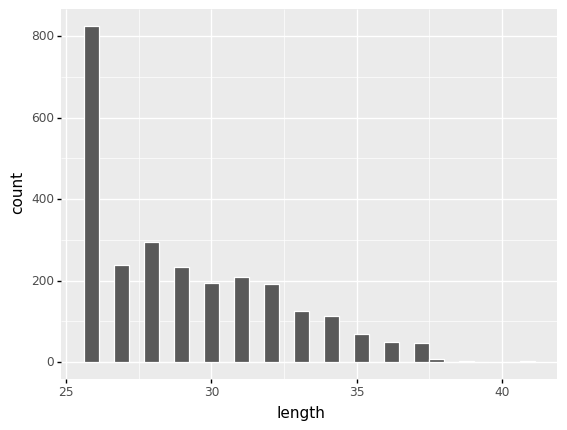

<bound method ggplot.draw of <ggplot: (8770690360031)>>

In [69]:
p = (ggplot(variant_usher_primers) + 
     aes('length') + 
     geom_histogram(color='white',bins=30)
    )

p.draw

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


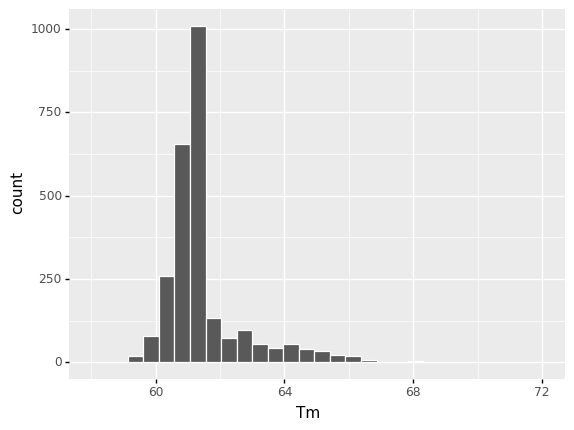

<bound method ggplot.draw of <ggplot: (8770689689450)>>

In [70]:
p = (ggplot(variant_usher_primers) + 
     aes('Tm') + 
     geom_histogram(color='white', bins=30)+
     xlim(58,72)
    )

p.draw

In [71]:
statistics.pvariance(variant_usher_primers['Tm'])

1.649630720798576